In [1]:
%%capture --no-display
!pip install jupyterlab_execute_time

In [2]:
import npu

# vector length; must be divisible by 4
vector_size = 2**4 # 16
# vector_size = 256
# vector_size = 16
# vectors are stored in row major form matrix A and B

Create Kernel

In [3]:
%%kernel 
void vector_multiother(uint32_t *in1_buffer, uint8_t *in2_buffer, uint8_t *out_buffer, uint32_t nbytes)
{
    // nbytes is the size of the vector
    for(int i=0; i<nbytes; i++) {
        for(int j = 0; j<nbytes; j++){
            for(int k = 0; k<nbytes; k++){
                out_buffer[i * nbytes + j] += in1_buffer[i * nbytes + k] * in2_buffer[k * nbytes + j];
            }
        }
    }
}

In [4]:
%%kernel 
void vector_multi(uint8_t *in1_buffer, uint8_t *in2_buffer, uint8_t *out_buffer, uint32_t nbytes)
{
    for(int i=0; i < nbytes; i++) {
        for(int j = 0; j < nbytes; j++){
            int sum = 0;
            for(int k = 0; k < nbytes; k++){
                sum += in1_buffer[i * nbytes + k] * in2_buffer[k * nbytes + j];
            }
            out_buffer[i*nbytes + j] = sum;
        }
    }
}

Create app builder

In [5]:
from npu.build.kernel import Kernel
from npu.build.appbuilder import AppBuilder
import numpy as np
from npu.build.itkernel import ITWrite
import math 

def _simple_behavioural(invobj):
    invobj.out_buffer.array = invobj.in1_buffer.array

class SimpleApplication(AppBuilder):

    def __init__(self, kernel:Kernel):
        self.kernel = kernel
        self.kernel.behavioralfx = _simple_behavioural
        super().__init__()

    def callgraph(self, x_in1: np.ndarray, x_in2: np.ndarray, x_out: np.ndarray) -> None:
        # nbytes = x_in1.shape[0]
        # test w/ 4
        root_size = int(math.sqrt(x_in1.shape[0]))
        print(root_size)
        result = self.kernel(x_in1, x_in2, root_size)
        _ = ITWrite(result, bufref=x_out)

4
4


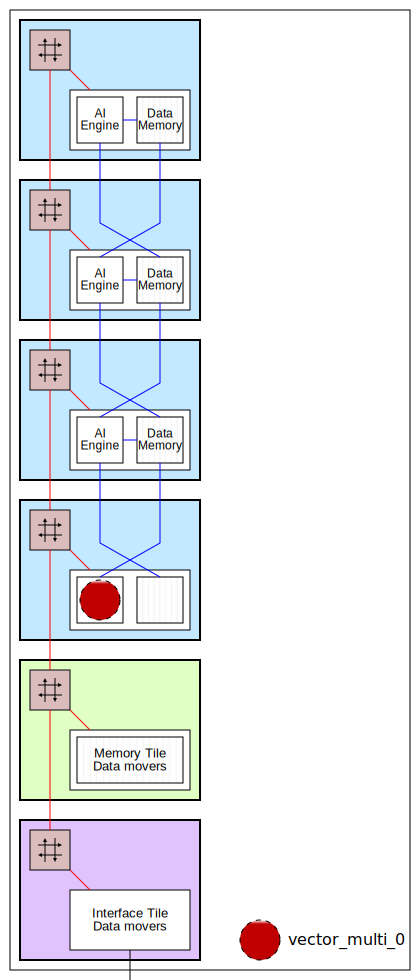

4


In [6]:
x_in1 = np.zeros(shape=(vector_size), dtype=np.uint8)
x_in2 = np.zeros(shape=(vector_size), dtype=np.uint8)
x_out = np.zeros(shape=(vector_size), dtype=np.uint8)

app_builder = SimpleApplication(kernel=vector_multi)
app_builder(x_in1, x_in2, x_out)

app_builder.display()
app_builder.save()

Build the app

In [7]:
app_builder.build(x_in1, x_in2, x_out)

4
4
Using cached vector_multi kernel object file...
Building the xclbin...
Successfully Building Application... SimpleApplication.xclbin & SimpleApplication.seq delivered


In [8]:
app_builder.metadata

4


{'application': 'SimpleApplication',
 'kernels': OrderedDict([('itbuffer_0',
               {'name': 'itbuffer_0',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin': {'c_dtype': None,
                  'direction': 'in',
                  'name': 'ITin',
                  'ctype': None,
                  'shape': (16,),
                  'dtype': 'uint8'},
                 'ITout': {'c_dtype': None,
                  'direction': 'out',
                  'name': 'ITout',
                  'ctype': None,
                  'shape': (16,),
                  'dtype': 'uint8'}},
                'shape': (16,),
                'dtype': 'uint8'}),
              ('itbuffer_1',
               {'name': 'itbuffer_1',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin': {'c_dtype': Non

Prep AppRunner and data

In [9]:
from npu.runtime import AppRunner

app = AppRunner('SimpleApplication.xclbin')

# Allocate app input and output buffers to exchange data with NPU
input1_vector = app.allocate(shape=(vector_size))
input2_vector = app.allocate(shape=(vector_size))
output_vector = app.allocate(shape=(vector_size))

# Load data
# 2**7 - 2**3 = 2**4 = 16
input1_array = np.zeros(vector_size, dtype=np.uint8)
#print(input1_array.shape)
input2_array = np.zeros(vector_size, dtype=np.uint8)
for i in range(vector_size):
    if i% 5 == 0: 
        input1_array[i] = 1
        input2_array[i] = 1
    else:
        input1_array[i] = i % 5
        input2_array[i] = i % 5

input1_vector[:] = input1_array
input2_vector[:] = input2_array

Run the application

In [10]:
# Pass input_vector buffer to NPU
input1_vector.sync_to_npu()
input2_vector.sync_to_npu()

In [11]:
# Run app on NPU
app.call(input1_vector, input2_vector, output_vector)

In [12]:
# Get results from NPU via output_vector buffer 
output_vector.sync_from_npu()

In [13]:
# Verify output
print(input1_vector.shape)
print(input2_vector.shape)
print(input1_vector)
print(input2_vector)
print(output_vector)

(16,)
(16,)
[1 1 2 3 4 1 1 2 3 4 1 1 2 3 4 1]
[1 1 2 3 4 1 1 2 3 4 1 1 2 3 4 1]
[17 19 17 10 15 15 18 17 24 14 15 19 28 24 15 17]


In [14]:
del app